# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import albumentations as A
import numpy as np
from albumentations.pytorch import ToTensorV2


## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


In [2]:

a_train_transforms = A.Compose([
    A.PadIfNeeded(min_height=36, min_width=36, always_apply=True, p=1),
    A.RandomCrop(height=32, width=32, always_apply=True, p=1),
    A.HorizontalFlip(p=0.5),
    A.CoarseDropout(max_holes=1, max_height=8, max_width=8, min_holes=1, min_height=8, min_width=8,always_apply=False,fill_value=(0.5, 0.5, 0.5)),
    A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ToTensorV2()
])

a_test_transforms = A.Compose([
    A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ToTensorV2()
])

# Dataset and Creating Train/Test Split

In [3]:
def get_augmentation(transforms):
    return lambda img: transforms(image=np.array(img))['image']
train = datasets.CIFAR10('./data', train=True, download=True, transform=get_augmentation(a_train_transforms))
test = datasets.CIFAR10('./data', train=False, download=True, transform=get_augmentation(a_test_transforms))

100%|██████████| 170498071/170498071 [00:05<00:00, 28541900.47it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [5]:
len(train_loader)

98

# The model
Let's start with the model we first saw

In [6]:
import torch.nn.functional as F
dropout_value = 0.05
from model import CustomResnet


# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [7]:
# !pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = CustomResnet().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1,

# Training and Testing

All right, so we have 24M params, and that's too many, we know that. But the purpose of this notebook is to set things right for our future experiments.

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [8]:
# from utils import train, test



from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, criterion, scheduler, epoch):
  model.train()
  pbar = tqdm(train_loader)

  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = criterion(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()
    scheduler.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)


    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()    # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [9]:
!pip install torch-lr-finder


In [10]:
from utils import get_lr
from torch_lr_finder import LRFinder



/usr/local/lib/python3.10/dist-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [11]:
optimizer = optim.Adam(model.parameters(), lr=0.03, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss(reduction="sum")

  0%|          | 0/98 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 8.18E-02


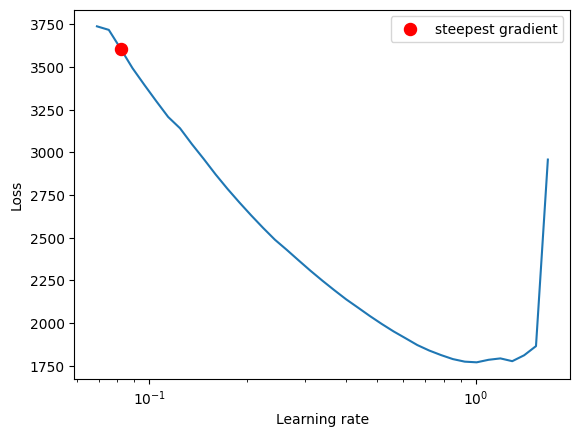

In [12]:

lr_finder = LRFinder(model, optimizer, criterion, device)
lr_finder.range_test(train_loader, end_lr=100, num_iter=len(train_loader))
lr_finder.plot()
lr_finder.reset()

In [13]:
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import OneCycleLR

model =  CustomResnet().to(device)

optimizer = optim.Adam(model.parameters(), lr=8.18E-02)

EPOCHS = 24
scheduler = OneCycleLR(
    optimizer,
    max_lr = 8.18E-02,
    steps_per_epoch = len(train_loader),
    epochs = EPOCHS,
    pct_start = 5/EPOCHS,
    div_factor = 100,
    three_phase = False,
    final_div_factor = 100,
)

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, criterion, scheduler, epoch)
    print("learning rate : ",get_lr(optimizer))
    test(model, device, test_loader, criterion)

EPOCH: 0


Loss=382.3751220703125 Batch_id=97 Accuracy=51.03: 100%|██████████| 98/98 [00:21<00:00,  4.60it/s]

learning rate :  0.008581700668242834



Test set: Average loss: 1.1380, Accuracy: 6190/10000 (61.90%)

EPOCH: 1


Loss=367.0028076171875 Batch_id=97 Accuracy=67.85: 100%|██████████| 98/98 [00:23<00:00,  4.14it/s]

learning rate :  0.028895595487864807



Test set: Average loss: 3.2425, Accuracy: 4829/10000 (48.29%)

EPOCH: 2


Loss=268.61993408203125 Batch_id=97 Accuracy=73.51: 100%|██████████| 98/98 [00:20<00:00,  4.72it/s]

learning rate :  0.05396975589272955



Test set: Average loss: 1.0205, Accuracy: 6837/10000 (68.37%)

EPOCH: 3


Loss=198.5724334716797 Batch_id=97 Accuracy=77.99: 100%|██████████| 98/98 [00:20<00:00,  4.70it/s]

learning rate :  0.07418879693848518



Test set: Average loss: 0.7598, Accuracy: 7703/10000 (77.03%)

EPOCH: 4


Loss=179.21144104003906 Batch_id=97 Accuracy=80.56: 100%|██████████| 98/98 [00:20<00:00,  4.73it/s]

learning rate :  0.0817999417909958



Test set: Average loss: 0.6687, Accuracy: 7827/10000 (78.27%)

EPOCH: 5


Loss=248.63970947265625 Batch_id=97 Accuracy=82.35: 100%|██████████| 98/98 [00:20<00:00,  4.76it/s]

learning rate :  0.08123081862931816



Test set: Average loss: 1.0204, Accuracy: 7114/10000 (71.14%)

EPOCH: 6


Loss=166.4956817626953 Batch_id=97 Accuracy=83.99: 100%|██████████| 98/98 [00:21<00:00,  4.63it/s]

learning rate :  0.07956168743456848



Test set: Average loss: 0.6071, Accuracy: 8080/10000 (80.80%)

EPOCH: 7


Loss=126.81035614013672 Batch_id=97 Accuracy=85.43: 100%|██████████| 98/98 [00:21<00:00,  4.64it/s]

learning rate :  0.07683807775463927



Test set: Average loss: 0.5200, Accuracy: 8300/10000 (83.00%)

EPOCH: 8


Loss=127.10946655273438 Batch_id=97 Accuracy=86.59: 100%|██████████| 98/98 [00:20<00:00,  4.77it/s]

learning rate :  0.07313428256167841



Test set: Average loss: 0.4814, Accuracy: 8471/10000 (84.71%)

EPOCH: 9


Loss=123.40493774414062 Batch_id=97 Accuracy=87.93: 100%|██████████| 98/98 [00:20<00:00,  4.79it/s]

learning rate :  0.06855133173347643



Test set: Average loss: 0.6674, Accuracy: 8209/10000 (82.09%)

EPOCH: 10


Loss=100.85253143310547 Batch_id=97 Accuracy=88.83: 100%|██████████| 98/98 [00:22<00:00,  4.38it/s]

learning rate :  0.06321423622176549



Test set: Average loss: 0.5407, Accuracy: 8384/10000 (83.84%)

EPOCH: 11


Loss=132.16085815429688 Batch_id=97 Accuracy=90.05: 100%|██████████| 98/98 [00:21<00:00,  4.65it/s]

learning rate :  0.057268578079335435



Test set: Average loss: 0.4364, Accuracy: 8690/10000 (86.90%)

EPOCH: 12


Loss=71.20252990722656 Batch_id=97 Accuracy=90.84: 100%|██████████| 98/98 [00:20<00:00,  4.74it/s]

learning rate :  0.05087653936113773



Test set: Average loss: 0.4407, Accuracy: 8689/10000 (86.89%)

EPOCH: 13


Loss=97.4869613647461 Batch_id=97 Accuracy=91.64: 100%|██████████| 98/98 [00:20<00:00,  4.78it/s]

learning rate :  0.044212478220603486



Test set: Average loss: 0.3585, Accuracy: 8902/10000 (89.02%)

EPOCH: 14


Loss=85.09134674072266 Batch_id=97 Accuracy=92.92: 100%|██████████| 98/98 [00:21<00:00,  4.61it/s]

learning rate :  0.03745817287373561



Test set: Average loss: 0.3782, Accuracy: 8855/10000 (88.55%)

EPOCH: 15


Loss=92.65876007080078 Batch_id=97 Accuracy=93.91: 100%|██████████| 98/98 [00:24<00:00,  3.96it/s]

learning rate :  0.03079786316323669



Test set: Average loss: 0.3685, Accuracy: 8931/10000 (89.31%)

EPOCH: 16


Loss=74.83340454101562 Batch_id=97 Accuracy=95.03: 100%|██████████| 98/98 [00:20<00:00,  4.79it/s]

learning rate :  0.024413224975877525



Test set: Average loss: 0.3273, Accuracy: 9065/10000 (90.65%)

EPOCH: 17


Loss=34.81334686279297 Batch_id=97 Accuracy=95.68: 100%|██████████| 98/98 [00:20<00:00,  4.69it/s]

learning rate :  0.018478414597899683



Test set: Average loss: 0.3107, Accuracy: 9099/10000 (90.99%)

EPOCH: 18


Loss=56.155094146728516 Batch_id=97 Accuracy=96.49: 100%|██████████| 98/98 [00:20<00:00,  4.76it/s]

learning rate :  0.013155318185518423



Test set: Average loss: 0.3069, Accuracy: 9149/10000 (91.49%)

EPOCH: 19


Loss=64.41868591308594 Batch_id=97 Accuracy=97.17: 100%|██████████| 98/98 [00:20<00:00,  4.82it/s]

learning rate :  0.008589135932586743



Test set: Average loss: 0.3004, Accuracy: 9200/10000 (92.00%)

EPOCH: 20


Loss=25.75326156616211 Batch_id=97 Accuracy=97.54: 100%|██████████| 98/98 [00:21<00:00,  4.59it/s]

learning rate :  0.004904421387815904



Test set: Average loss: 0.3010, Accuracy: 9209/10000 (92.09%)

EPOCH: 21


Loss=14.236180305480957 Batch_id=97 Accuracy=98.12: 100%|██████████| 98/98 [00:20<00:00,  4.78it/s]

learning rate :  0.0022016839586532903



Test set: Average loss: 0.2917, Accuracy: 9240/10000 (92.40%)

EPOCH: 22


Loss=30.35257911682129 Batch_id=97 Accuracy=98.17: 100%|██████████| 98/98 [00:20<00:00,  4.77it/s]

learning rate :  0.0005546472766558273



Test set: Average loss: 0.2923, Accuracy: 9246/10000 (92.46%)

EPOCH: 23


Loss=13.352054595947266 Batch_id=97 Accuracy=98.20: 100%|██████████| 98/98 [00:20<00:00,  4.69it/s]

learning rate :  8.238209004209901e-06



Test set: Average loss: 0.2905, Accuracy: 9255/10000 (92.55%)



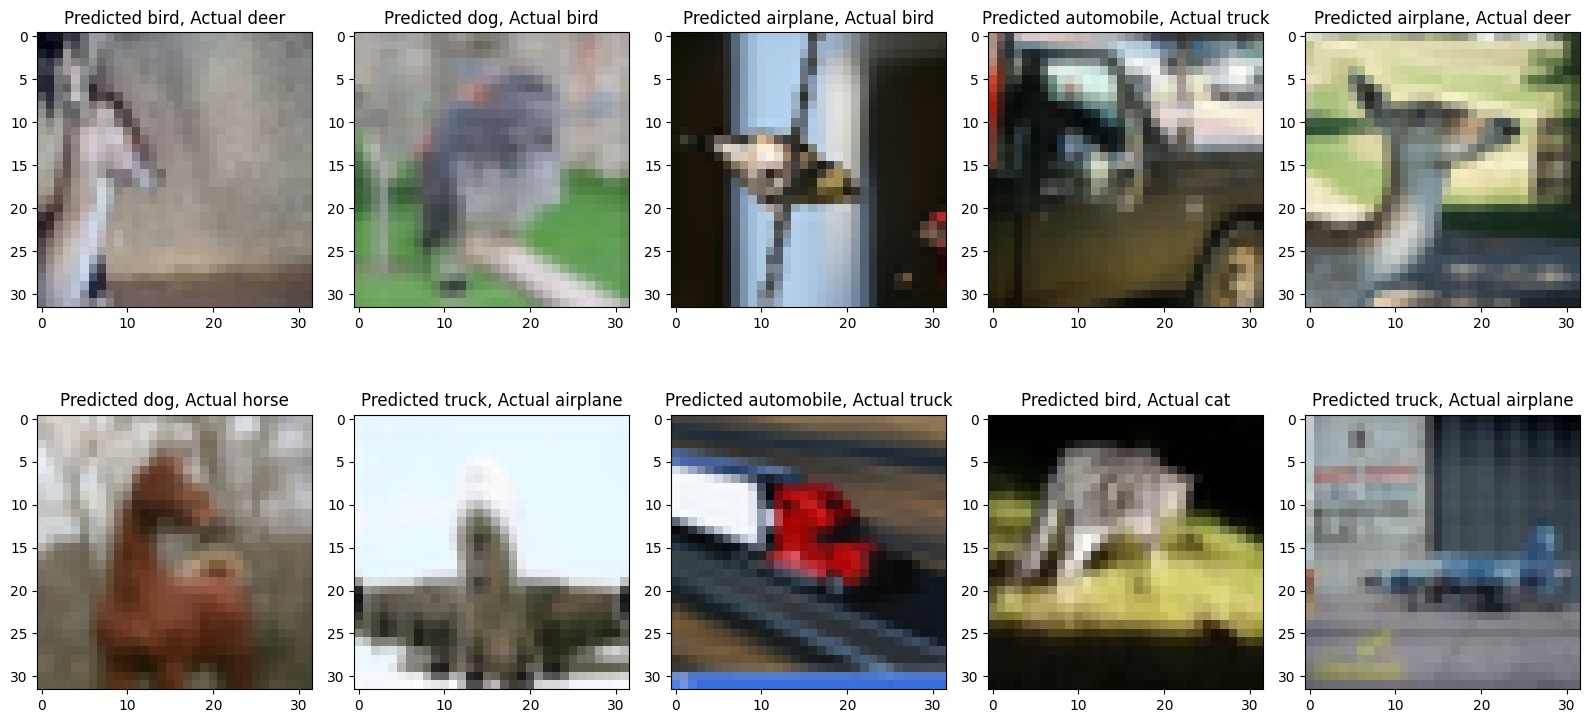

In [14]:
import matplotlib.pyplot as plt
import numpy as np

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
from utils import get_incorrect_images
get_incorrect_images(model,test_loader,n=10)
